# Estimating Color Names by Web Image Searches
Students: Dominik SCHREIBER and Elizabeth WALTON

This project focuses on how to use easily accessible image data from the internet in order to "teach" a program what the most common color values mean. In other words: Given an RGB color, what is the most likely name for this color?

One important underlying principle for our project is that data retrieved by a web search (e.g. Yahoo or Google) is already intrinsically labeled (albeit noisy) by the used **search term**. Consequently, we retrieved a number of images from web searches and were able to perform supervised learning on the images' mean colors and their labels.

Another important detail of our procedure is that we do not use the RGB value of the resulting mean color, but the two-dimensional chrominance value. Assuming an RGB color `(r,g,b)`, the chrominance value is calculated as `(c1, c2) = (r/(r+g+b), g/(r+g+b))`. The chrominance value  drops the brightness (*luminance*) of the color, only keeping the shares of red, green and blue. This reduction of dimensionality also reduces the complexity of the problem, and allows us to focus on the color hue without considering the illumination. 

We have a couple of hypotheses on which we would like to focus. These hypotheses include the following:

1. The intrinsically labeled color images acquired from an internet search represent the true distribution of colors on a chrominance plane. 
1. We can use the acquired data to predict the color of an image with a reasonable accuracy, i.e. at the very least better than a random guess.
1. We can improve the prediction results by performing an a-priori outlier elimination in order to filter out false data points.
1. The variance of a color correlates with the correct prediction error in such a way that colors with a high variance will lead to a higher likelihood that the color of an image is incorrectly predicted.

## Procedure

In the following points, we describe our general approach for this project and its implementation.

All in all, we perform the following steps:

* For a defined list of colors, we retrieve images by web search queries.
* We calculate the mean color value of each image, using a Gaussian perceptive field function centered over the image.
* An outlier elimination is performed in order to omit samples which are inaccurate (e.g. a blue image retrieved from a search for "red").
* We train a classification model on the training data.
* We test the learned model with different images retrieved by web searches.

We write intermediate results (such as the raw color values or the later test results) into files in order to reduce neccessity to recalculate results as well as for the ability to easily input the results into external applications, if desired.

We do not describe the technical procedure of retrieving the images from web searches; instead we directly use the downloaded images inside the local directory.

There are some parametrizations that we use when filtering data and training the models. We note that in the scope of this work, we do not try to find the globally best model that could be trained from the given data, neither do we claim to have found the best possible parametrizations.  

### Preparations

We have defined a number of color names among which we would like to classify arbitrary color values.

In [4]:
# Read colors from a textfile
colornames = open("colornames").read().splitlines()
print(colornames)

['pink', 'magenta', 'red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'violet', 'purple', 'brown', 'beige', 'white', 'gray', 'black']


In [10]:
# Imports for the entire notebook
from sys import stdout
import csv
import math
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import arange
import numpy.linalg as la
import cv2
from PIL import Image, ImageDraw
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import random
random.seed(1337)

# Some preferences for a correct and tidy display of the results and plots
font = {'size'   : 17}
matplotlib.rc('font', **font)
figuresize_quad = (10, 10)
figuresize_rect = (10, 7)

import warnings
warnings.filterwarnings("ignore")

### Extracting raw color data

To get an impression of what the web search results look like, all the used training images for the colors blue and cyan are displayed below. 

#### Blue training images

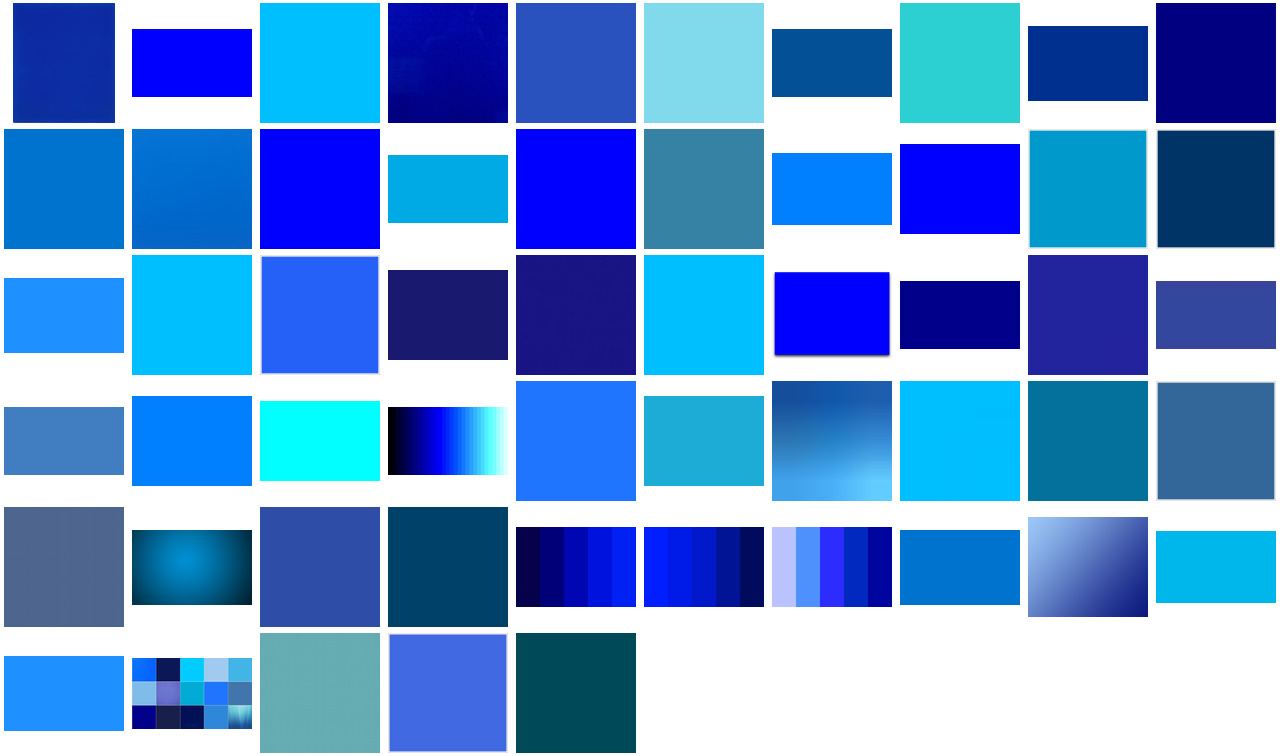

#### Cyan training images

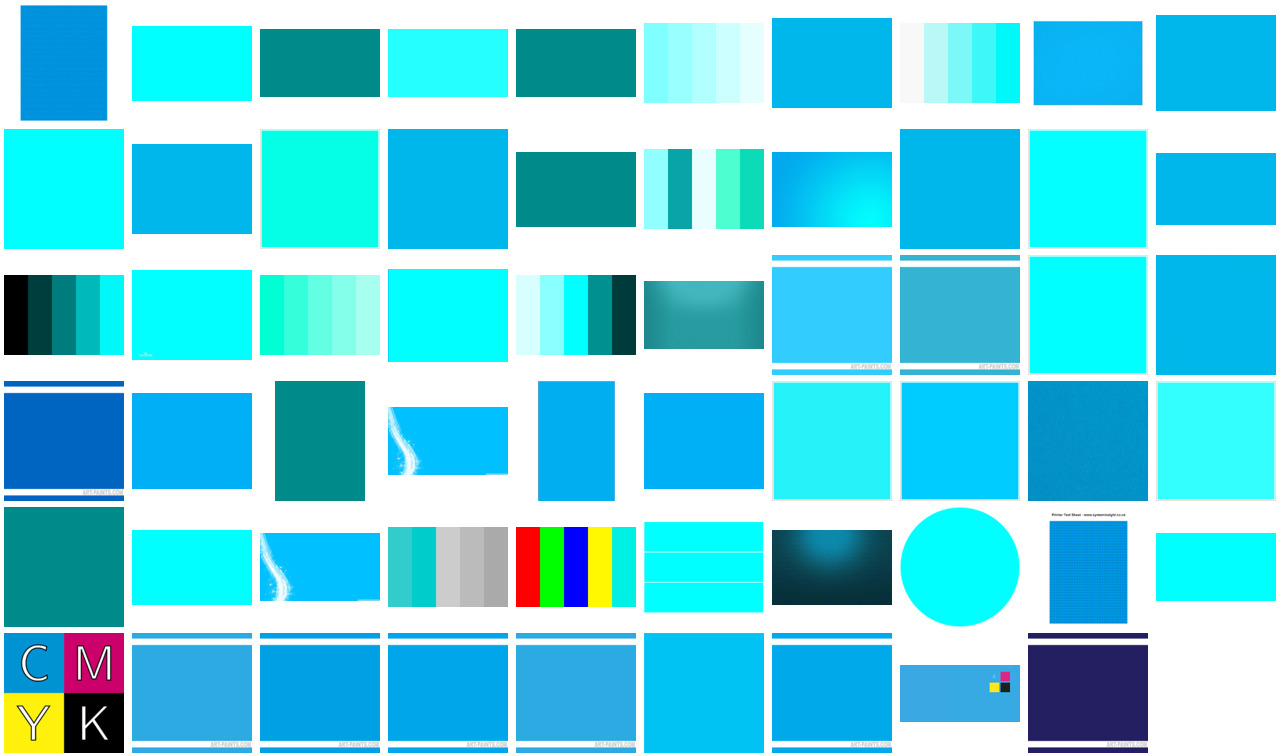

For each of the approximately 800 downloaded images from the Yahoo! web search (50 images per each of the 16 color names) with their corresponding search string as labels (e.g. "blue", "green"), we calculate the perceived color of each image with a Gaussian perceptive field function at the center of the image.

In [175]:
# Gaussian perceptive field function
def gauss(x, y, sigma):
    return 1/(2*math.pi*sigma**2)*math.exp(-0.5*((x**2+y**2)/sigma**2))

# Calculates the average color of the image's center, weighted w/ perceptive field
def perceived_color(img):
    # Parameters for perceptive field
    width, height = img.shape[:2]
    gauss_radius = min(width, height) / 4
    sigma = gauss_radius / 3
    # Convolution of image center with perceptive field
    color = [0., 0., 0.]
    for x in range(width):
        for y in range(height):
            share = gauss(x - width / 2, y - height / 2, sigma)
            color += share * img[x, y]
    # Convert into chrominance space
    red, gre, blu = (color[2], color[1], color[0])
    lum = red+gre+blu
    if lum == 0:
        color = [1.0/3, 1.0/3] # pure black
    else:
        color = [red/(red+gre+blu), gre/(red+gre+blu)]
    return color

In [177]:
# Process each color
stdout.write('Processing ')
for colorname in colornames:
    stdout.write(colorname)
    data = []
    
    # Interpret up to 100 images for the given color name
    for i in range(1, 100):
        img = cv2.imread("data/color_" + colorname + "/" + str(i) + ".jpg", cv2.IMREAD_COLOR) 
        if img is not None:
            data += [perceived_color(img)]
    
    # Output results to file
    f_out = open("data/colorvalues_" + colorname + "_raw", 'w')
    for x in data:
        f_out.write(str(x[0]) + " " + str(x[1]) + "\n")
    f_out.close()
    stdout.write(', ')
    
print("done.")

Processing pink, magenta, red, orange, yellow, green, cyan, blue, violet, purple, brown, beige, white, gray, black, done.


### Statistical filtering

We also apply an outlier elimination in order to remove false data points, e.g. a blue image which is part of the results of "red". We will compare how a model trained on this filtered data performs versus a model trained on raw, unfiltered data. We have 10% of all data points eliminated and use a Nearest Neighbor metric which operates on the respective 50 nearest data points in order to get a very "global" notion of outlier-ness.

In [178]:
for colorname in colornames:
    # Read raw color data
    f = open("data/colorvalues_" + colorname + "_raw", 'r')
    data = [[float(x[0]), float(x[1])] for x in csv.reader(f, delimiter=' ')]
    f.close()
    
    # Eliminate noise / outliers
    clf = LocalOutlierFactor(n_neighbors=50, contamination=0.10)
    y_pred = clf.fit_predict(data)
    data = [data[i] for i in range(len(data)) if y_pred[i] == 1]
    
    # Output results to file
    f_out = open("data/colorvalues_" + colorname + "_filtered", 'w')
    for x in data:
        f_out.write(str(x[0]) + " " + str(x[1]) + "\n")
    f_out.close() 

### Displaying the training data

To get an overview of how the collected, filtered data is distributed, we plot the chrominance plane with each data point colored with its corresponding color label.

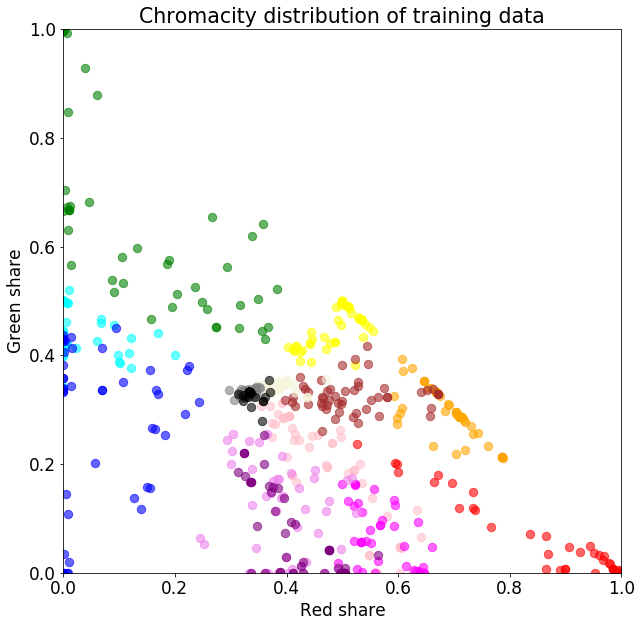

In [179]:
fig, ax = plt.subplots(figsize=figuresize_quad)

# Add samples for each used color to the plot
for colorname in colornames:
    f = open("data/colorvalues_" + colorname + "_filtered", 'r')
    x, y = [], []
    for row in csv.reader(f, delimiter=' '):
        x += [float(row[0])]
        y += [float(row[1])]
    f.close()
    ax.scatter(x, y, c=colorname, s=70, marker='o', alpha=0.6)

# Display plot
plt.title('Chrominance distribution of training data')
ax.set_xlabel('Red share')
ax.set_ylabel('Green share')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
plt.show()

In the distribution above, it can be seen that the red and green values for each point sums to at most 1.0, with the remaining share being attributed to blue. That statement is the reason that all the data points plot on or below the line `y = x - 1`. Also note that the images color white, gray, or black are all plotted around the same point, `(1/3, 1/3)`. This plotting occurs because colors have equal shares of red, green and blue. White, gray, and black colors differ only on their amount of luminance. Therefore, when estimating the name of a color, it can be easily checked whether the chrominance lies inside a small disk around this point; if so, the color name can be inferred as white, gray or black by using thresholds on the color's luminance (almost no luminance - black, almost complete luminance - white, else - gray). This is why we will drop these colors of constant chrominance when training the model later.

Lastly, a limitation of this procedure is the fact that we do not have a color point at each coordinate within the chrominance plane, as can be seen by the blank space among the color points. This could be attributed to a lack of images or data points in general, the absence of some color names searched and included that are needed to cover the entire chrominance space, or just that some areas of the plane are comparably insignificant. However, given that it is a simple color model, the distribution on the chrominance plane is reasonable for the colors we searched, supporting our first hypothesis.  

As seen in the section below, when the model is trained, these points will be grouped and transformed to color classification regions within the chrominance space. However, because of the blank space, some color classification regions will be arbitrarily estimated. This means that if we use this data to try to predict the color of an image whose (r,g,b) value maps to a blank space in this graph, the probability that that color is predicted correctly is decreased.

### Training a prediction model

From the collected training data, we can now train a prediction model. First, we perform an adjustment for simplicity: We do not use the white, gray, and black samples since they ideally map to a disk around one single point, `(1/3, 1/3)`, on the chrominance plane, as explained above. So at this point of the procedure, we are not particularly interested in them.

In [6]:
# Load training data
X, Y = [], []
X_filtered, Y_filtered = [], []
for i in range(len(colornames)):
    color = colornames[i]
    f = open("data/colorvalues_" + color + "_filtered", 'r')
    for row in csv.reader(f, delimiter=' '):
        X_filtered += [[float(row[0]), float(row[1])]]
        Y_filtered += [i]
    f.close()
    f = open("data/colorvalues_" + color + "_raw", 'r')
    for row in csv.reader(f, delimiter=' '):
        X += [[float(row[0]), float(row[1])]]
        Y += [i]
    f.close()

def adjust_data(X, Y):
    random.seed(1337)
    # Turn black and white into gray
    for i in range(len(Y)):
        if colornames[Y[i]] in ['white', 'black']:
            Y[i] = colornames.index('gray')   
    # Eliminate gray/white/black
    bgw_indices = [i for i in range(len(Y)) if colornames[Y[i]] in ['black', 'gray', 'white']]
    for i in sorted(bgw_indices, reverse=True):
        del X[i]
        del Y[i]

def write_data(X, Y, filename_suffix):
    # Write final training data (for later analysis)
    for i in range(len(colornames)):
        color = colornames[i]
        X_color = [X[i] for i in range(len(X)) if colornames[Y[i]] == color]
        if X_color:
            f = open("data/colorvalues_" + color + filename_suffix, 'w')
            for x in X_color:
                f.write(str(x[0]) + " " + str(x[1]) + "\n")
            f.close()

adjust_data(X_filtered, Y_filtered)
adjust_data(X, Y)
write_data(X_filtered, Y_filtered, "_filtered_adjusted")
write_data(X, Y, "_adjusted")

The following parameters can be tuned to change between a Neural Network classifier and a Nearest Neighbor model as well as to parametrize said chosen classifier. We did not do a structured and thorough evaluation of the different parametrizations, but various ad-hoc tests yielded that a neural network with two layers of 25 units each performs rather well on our data.

In [2]:
# Tuneable parameters
useMlp = True # False for NearestNeighbor model, True for MLP model
neighbors = 10 # Parameter for NearestNeighbor model
hiddenLayers = (25,25) # Hidden layers and their sizes for MLP model

Now, we train identically parametrized models both on the filtered and unfiltered data.

In [7]:
# Train a classifier
if useMlp:
    clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=hiddenLayers, random_state=1, 
                        max_iter=1000000, alpha=1e-02)
else:
    clf = KNeighborsClassifier(n_neighbors=neighbors)
clf_filtered = deepcopy(clf)
clf.fit(np.array(X), np.array(Y))
clf_filtered.fit(np.array(X_filtered), np.array(Y_filtered))

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(25, 25), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

### Displaying the results

The figure rendered by this code snippet displays the predicted color name of each pixel on the chromatic plane in the lower left triangle and its actual color appearance in the upper right triangle, mirrored on the diagonal of the image. We visualize the model both from unfiltered and filtered data.

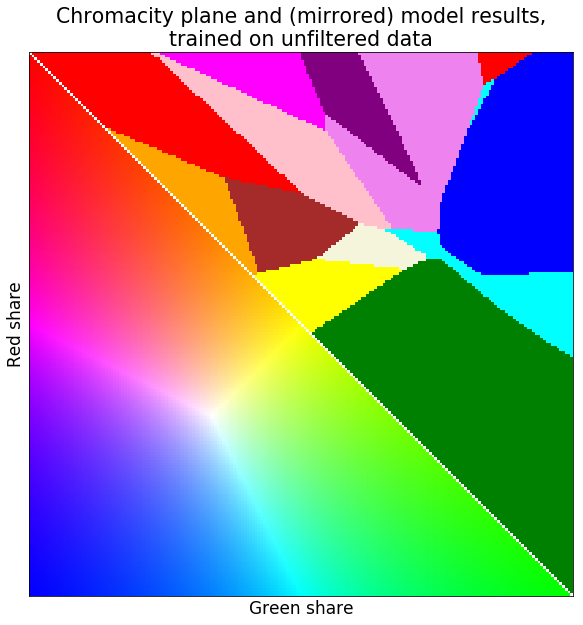

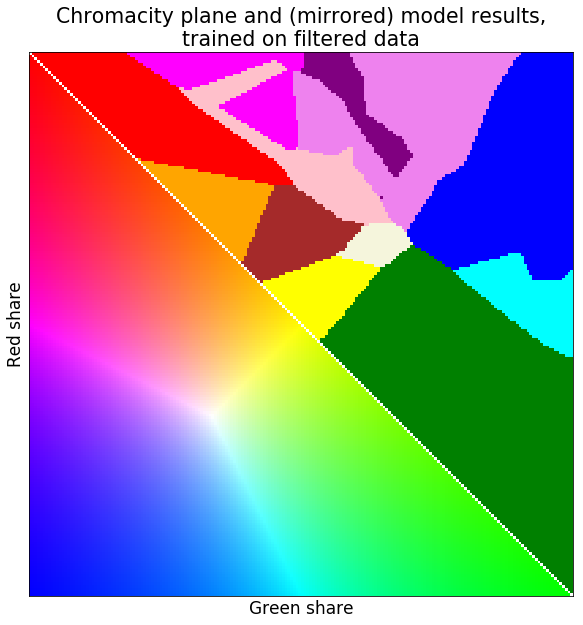

In [12]:
def plot_model_results(clf, title_suffix):
    # Prepare empty image 
    step = 0.5
    width = int(100/step)
    im = Image.new('RGB', (width, width), (255, 255, 255)) 
    draw = ImageDraw.Draw(im)

    # Draw prediction triangle
    for c2 in arange(0,100,step):
        for c1 in arange(0,100-c2,step):
            draw.point((width - c1/step, c2/step), fill=colornames[int(clf.predict([[c1/100.0, c2/100.0]]))])
    # Draw true chrominance triangle
    for c2 in arange(0,100,step):
        for c1 in arange(0,100-c2,step):
            b = 100 - c2 - c1
            max_comp = max(0.01*c1, max(0.01*c2, 0.01*b))
            factor = 2.55 / max_comp
            draw.point((width - (100-c2)/step, (100-c1)/step), fill=(int(factor*c1),int(factor*c2),int(factor*b)))

    # Save model image
    im.save("model.png", "PNG")

    # Plot model image
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=figuresize_quad)
    ax1 = plt.imshow(im, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("Green share")
    ax.set_ylabel("Red share")
    plt.title("Chrominance plane and (mirrored) model results,\n" + title_suffix)
    plt.show()

plot_model_results(clf, "trained on unfiltered data")
plot_model_results(clf_filtered, "trained on filtered data")

The lower triangle, the chrominance plane, shows where each color should be mapped and the upper triangle shows how each color is mapped using our model. If there were no flaws in the model, the triangular regions should map such that they reflect each other perfectly (in the sense that the intuitive names for the above regions' colors match the corresponding lower region very well). As seen, the blank regions in the chrominance distribution in a previous section have caused some of the borders of the regions mapped, like the border between the red classification region and the pink classification region, to be inaccurate. 

When comparing the unfiltered and the filtered model, there is for example a small red triangle learned with unfiltered data at a point where there should hardly be any red (top right corner, so an almost pure blue). The model from filtered data does not have this red region. This indicates that at least some correction is being done by filtering the data.

### Testing the model

In order to test our model in a quantitative way, we took another set of web image search results. We queried Google instead of Yahoo, and performed a manual selection of the pictures which correspond to the correct color, manuaully filtering out false data points.

We realize that this test set has some form of bias, as it also only contains color hues which are retrieved from web searches. As we saw in a previous section, there are chrominance values which did not appear at all in the results, so this test set from a different web search provider is likely to include a bias of that kind as well. However, using this test set can yield a good first impression of the model's accuracy within the domain for which it was trained. For further analysis, a larger test set with images of real-world objects of various colors could be created such that the entire chrominance plane is nearly uniformly covered.

First, the names of the colors to test are read, and the color values of the test images are calculated.

In [13]:
# Read colors to test
colornames_test = open("colornames_test").read().splitlines()
print(colornames_test)

['pink', 'magenta', 'red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'violet', 'purple', 'brown', 'beige']


In [185]:
# Process images for each color to test
num_total_predictions = 0
num_total_correct_predictions = 0
pred = []
for colorname in colornames_test:
    data = []    
    # Interpret 20 images per given color name
    for i in range(1, 20):
        img = cv2.imread("data/test/" + colorname + "/testimage" + str(i) + ".jpg", cv2.IMREAD_COLOR) 
        if img is not None:
            data += [perceived_color(img)]
    # Output results to file
    f_out = open("data/test/colorvalues_" + colorname, 'w')
    for x in data:
        f_out.write(str(x[0]) + " " + str(x[1]) + "\n")
    f_out.close()

Then, we do the testing of the models and also calculate the accuracy of the predictions for each of the tested colors, which are printed below. 

In [14]:
# Load training data
test = []
for i in range(len(colornames_test)):
    color = colornames_test[i]
    f = open("data/test/colorvalues_" + color, 'r')
    data = [[float(x[0]), float(x[1])] for x in csv.reader(f, delimiter=' ')]
    test += [data]
    f.close()

def calc_accuracies(clf, filename_suffix):
    # Process each color
    num_total_predictions = 0
    num_total_correct_predictions = 0
    pred = []
    for i in range(len(colornames_test)):
        colorname = colornames_test[i]
        # Compare model prediction with reality
        num_predictions = 0
        num_correct_predictions = 0
        f_out = open("testresults_" + colorname + filename_suffix, 'w')
        for c in test[i]:
            prediction = int(clf.predict([c]))
            if colornames[prediction] == colorname:
                num_correct_predictions += 1
            num_predictions += 1
            f_out.write(str(prediction) + "\n")
        f_out.close()
        pred += [float(num_correct_predictions)/num_predictions]
        print("  " + (colorname + ":").ljust(16) + '{0:.2f}'.format(pred[-1]))
        num_total_predictions += num_predictions
        num_total_correct_predictions += num_correct_predictions    

    # Calculate total accuracy
    print("  Total accuracy: " + '{0:.2f}'.format(float(num_total_correct_predictions)/num_total_predictions))

    # Write accuracies to file
    f_out = open("accuracies" + filename_suffix, 'w')
    for i in range(len(pred)):
        f_out.write(colornames_test[i] + " " + str(pred[i]) + "\n")
    f_out.close()

print("Accuracies for model on unfiltered data:")
calc_accuracies(clf, "")
print("\nAccuracies for model on filtered data:")
calc_accuracies(clf_filtered, "_filtered")

Accuracies for model on unfiltered data:
  pink:           0.79
  magenta:        0.68
  red:            0.95
  orange:         0.63
  yellow:         0.89
  green:          0.95
  cyan:           0.79
  blue:           0.89
  violet:         0.42
  purple:         0.47
  brown:          0.84
  beige:          0.95
  Total accuracy: 0.77

Accuracies for model on filtered data:
  pink:           0.74
  magenta:        0.74
  red:            1.00
  orange:         0.79
  yellow:         0.95
  green:          0.95
  cyan:           0.84
  blue:           0.84
  violet:         0.63
  purple:         0.58
  brown:          0.74
  beige:          0.95
  Total accuracy: 0.81


These values represent the average prediction accuracy over the test set given a specific color. For example, on our reference parameters the model with filtering correctly labeled all of the red test images as "red" whereas it labeled only approximately 63% of the purple images as "purple". We will analyze these values in the next section.

With the raise of accuracy from 77% to 81% when using filtered data, we confirm the benefit of applying an a priori outlier elimination of the data. We see that such a filtering can indeed have a positive impact on the training and will from now on only analyze the results of the model trained on filtered data. That being said, we did not do an analysis of what would be the optimal parametrization for the filtering, so our results might still be suboptimal from this point of view.

##  Analysis

At this point, we have the results of our tests in text files and can interpret and analyze them.   
We use the following code snippets and two plots to look deeper at these conjectures. 

Firstly, we retrieve the results and normalize the prediction shares over the different predicted colors to sum up to 1.

In [187]:
# Read accuracies
accuracies = []
f = open("accuracies_filtered", 'r')
for row in csv.reader(f, delimiter=' '):
    accuracies += [float(row[1])]
f.close()
# Read results
results = []
for i in range(len(colornames_test)):
    colorname = colornames_test[i]
    f = open("testresults_" + colorname + "_filtered", 'r')
    for l in f.readlines():
        results += [(i, int(l))]

# Transform results
results_table = np.zeros((len(colornames_test), len(colornames_test)))
for result in results:
    results_table[result[0], result[1]] += 1.0/20

Next, we return to the training data and calculate the variances of the samples per color, as we suspect some correlation between these variances and the accuracies of predicting the colors.

In [188]:
# Statistics about training data
variances = []
for i in range(len(colornames_test)):
    colorname = colornames_test[i]
    X = []
    f = open("data/colorvalues_" + colorname + "_filtered_adjusted", 'r')
    for row in csv.reader(f, delimiter=' '):
        X += [[float(row[0]), float(row[1])]]
    f.close()
    mean_x = sum([x[0] for x in X]) / len(X)
    mean_y = sum([x[1] for x in X]) / len(X)
    mean = (mean_x, mean_y)
    variance = sum([la.norm([x[0] - mean_x, x[1] - mean_y])**2 for x in X])
    variances += [variance]

To get an intuition over the distributions of color labels that have been predicted for each of the "true" colors, we plot a heat map.

In [189]:
# Confusion Matrix
fig, ax = plt.subplots(figsize=figuresize_quad)
confusionmatrix = plt.imshow(results_table, cmap="Blues", interpolation='nearest')
ticks, ticklabels = (np.arange(len(colornames_test)), colornames_test)
ax.set_xticks(ticks, minor=False)
ax.set_yticks(ticks, minor=False)
ax.set_xticklabels(ticklabels, minor=False)
ax.set_yticklabels(ticklabels, minor=False)
plt.title("Confusion Matrix: truth vs. prediction")
plt.xlabel("True color")
plt.ylabel("Predicted color")
plt.xticks(rotation=90)
ax.invert_yaxis()
cbar = plt.colorbar(confusionmatrix, extend='neither')
cbar.set_label("Percentage over true color's predictions")
plt.show()

In [190]:
# Correlation of p(true|pred) vs. p(pred|true)
size = len(colornames_test)
a, b = [], []
for j in range(size):
    for i in range(j):
        a += [results_table[i, j]]
        b += [results_table[j, i]]
print("Correlation of (i,j) vs. (j,i) values: " + '{0:.2f}'.format(np.corrcoef(a, b)[0, 1]))

Correlation of (i,j) vs. (j,i) values: 0.90


With the chosen parameters of the training, we get a correlation coefficient of 0.9, which indicates some significant correlation. Although we drop the exact mapping between the cell values when computing the correlation, this can still indicate similar values in the upper vs. lower triangle. On an intuitive level, this somewhat symmetric behaviour implies that the model is most likely to confuse two colors with each other in an approximately balanced way. This means that the classification borders between the pairs of colors are mostly reasonable and not heavily shifted towards one of the two respective colors. 

This result also makes sense in an intuitive way of how humans percieve color: Mistaking one color as the other should be approximately symmetric, such that for example one person labels an object as blue whereas another person labels it as cyan. Many of these pairs that the model confuses are neighbors with respect to their wavelength (which can be seen from above plot as we ordered the colors approximately in a rainbow spectrum). 

As we suspect some relation between the variances of the colors' training data and their corresponding test accuracy, we plot a correlation plot and calculate the correlation coefficient for these datasets.

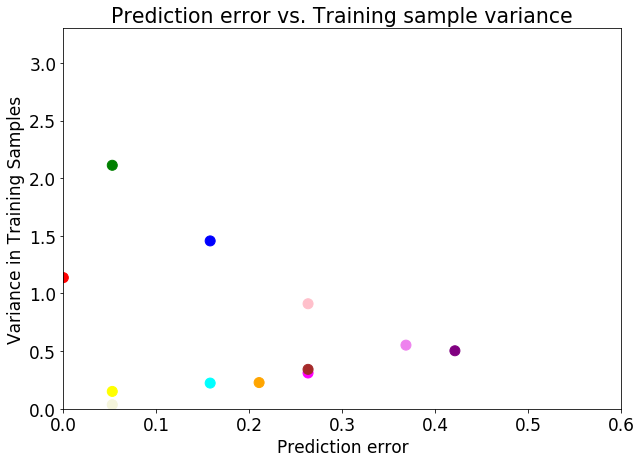

In [191]:
# Scatterplot of training set variances vs. prediction errors
x = np.array(accuracies)
x = 1 - x
y = variances
fig, ax = plt.subplots(figsize=figuresize_rect)
ax.scatter(x, y, s=100, c=colornames_test, marker='o')
plt.title("Prediction error vs. Training sample variance")
plt.xlabel("Prediction error")
plt.ylabel("Variance in Training Samples")
plt.xlim(0, 0.6)
plt.ylim(0, 3.3)
plt.show()

In [192]:
print("Correlation: " + '{0:.2f}'.format(np.corrcoef(x, y)[0, 1]))

Correlation: -0.26


As can be seen from the above plot and a correlation coefficient of -0.26, our third and final hypothesis which pertains to the correlation of the variances of the colors' training data with their corresponding test accuracy (or error rate) does not hold. Instead, other possibly far more complex factors influence the color-dependent accuracy of the model.  

## Conclusion

We have gone through the process of using web search images to train a model to recognize the names of given color values. We exploited the fact that images retrieved from a specific search string are already intrinsically labeled with this search string. 

Building the model inside chrominance-space and thus dropping one of the three dimensions of the RGB colors has not been a problem for training a model which recognized the test colors with an accuracy of up to 81%. We showed that an a priori outlier elimination can have a positive impact on the learned model. However, we concede that the testing process is slightly biased and these results are valid only for the space of colors which are retrieved by popular web searches.

We could not identify any correlation between the variance of a color's training data and the accuracy of its labeling. We found that the (mis)prediction distribution is symmetric to a certain degree, indicating a somewhat "natural behavior" and reasonable boundaries between adjacent colors.

For further research, the test dataset could be crafted manually out of many different objects which are representative for some color. For example, a picture of a leaf and a picture of grass could be used in the test dataset for the color labelled "green". Then, the model's accuracy can be accurately compared for differing parametrizations of a neural network and/or nearest neighbor classifier. Additionally, further training data augmentations such as we did with the 'lime' color could be performed and evaluated to improve the overall accuracy of the boundaries. Finally, randomness should be taken into account when evaluating models by training multiple instances of the Neural Network classifier with differing seeds and aggregating the respective results.

<!--
# Accuracy bar plot
x = np.arange(len(colornames_test))
y = np.array(accuracies)
fig, ax = plt.subplots(figsize=figuresize_rect)
ax2 = ax.twinx()
ax.bar(x-0.2, y, width=0.4, color='b', align='center')
ax.set_ylabel("Prediction accuracy")
ax.set_xticks(np.arange(len(colornames_test)), minor=False)
ax.set_xticklabels(colornames_test, minor=False, rotation=90)

ax2.bar(x+0.2, variances, width=0.4, color='g', align='center')
ax2.set_ylabel("Variance of training samples")
#plt.ylim(0.0, 1.0)
plt.title("Accuracy of predicting colors vs. training data variance")
plt.xlabel("True color")
#ax.bar(x, z,width=0.2,color='g',align='center')
#ax.bar(x+0.2, k,width=0.2,color='r',align='center')
plt.show()
-->